# **<span style="color:	#F50C0C;">Introduction</span>**

The dataframe consists of <b>162421</b> complaints for <b>5 products</b>. The dataframe is considerably <b>imbalanced</b>. 

The notebook implements <b>Bi-LSTM</b> model for <b>multiclass</b> classification of product complaints. Based on the provided <b>complaints</b>, the goal of the notebook is to accurately <b>identify the product</b>.    

# **<span style="color:	#F50C0C;">Import Libraries</span>**

In [1]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.python.client import device_lib
tf.test.gpu_device_name()

''

# **<span style="color:	#F50C0C;">1. Reading and Analyzing Dataframe</span>**

In [2]:
# Reading dataframe
df = pd.read_csv('C:/Work/Data Science/My portofolio/NLP/Customer Complain/complaints_processed.csv')
df.head()

,Unnamed: 0,product,narrative
0,0,credit_card,purchase order day shipping amount receive pro...
1,1,credit_card,forwarded message date tue subject please inve...
2,2,retail_banking,forwarded message cc sent friday pdt subject f...
3,3,credit_reporting,payment history missing credit report speciali...
4,4,credit_reporting,payment history missing credit report made mis...


In [3]:
# Renaming columns 
df = df.rename(columns={'narrative':'tweet' })

# Removing SNo column
df.drop(['Unnamed: 0'], axis=1, inplace=True)
df.head()

,product,tweet
0,credit_card,purchase order day shipping amount receive pro...
1,credit_card,forwarded message date tue subject please inve...
2,retail_banking,forwarded message cc sent friday pdt subject f...
3,credit_reporting,payment history missing credit report speciali...
4,credit_reporting,payment history missing credit report made mis...


In [4]:
# Analysing dataframe attributes 
print('* Size of dataframe: {}\n'.format(df.shape))
print('* Datatype of columns are:\n {}\n'.format(df.dtypes))
print('* Count of different product categories:\n {}\n'.format(df['product'].value_counts()))
print('* Number of NaNs among tweets are: {}\n'.format(df['tweet'].isnull().sum())) 

* Size of dataframe: (162421, 2)

* Datatype of columns are:
 product    object
tweet      object
dtype: object

* Count of different product categories:
 credit_reporting       91179
debt_collection        23150
mortgages_and_loans    18990
credit_card            15566
retail_banking         13536
Name: product, dtype: int64

* Number of NaNs among tweets are: 10



In [5]:
# Removing Null from dataset
df = df.dropna(subset=['tweet'])
print('NaNs are removed from the dataframe. Number of NaNs can be confirmed to be {}. The size of dataframe has reduced to {}'.format(df['tweet'].isnull().sum(), df.shape))

NaNs are removed from the dataframe. Number of NaNs can be confirmed to be 0. The size of dataframe has reduced to (162411, 2)


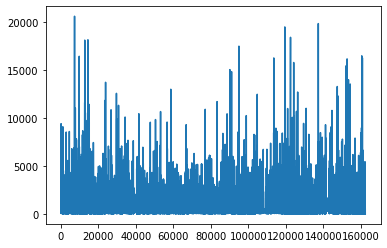

In [6]:
# Plotting Words Length of tweets
word_length = [len(x) for x in df['tweet']]
plt.plot(word_length)

In [7]:
# Converting Data type from sentences to string
df['product'].value_counts()

credit_reporting       91172
debt_collection        23148
mortgages_and_loans    18990
credit_card            15566
retail_banking         13535
Name: product, dtype: int64

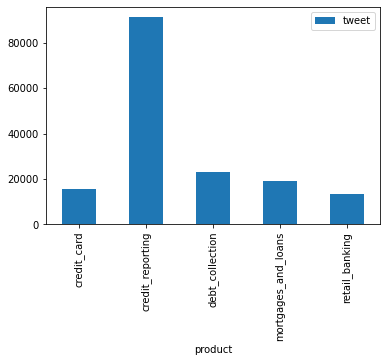

In [8]:
# Plotting product value counts
df.groupby('product').count().plot(kind='bar')
plt.show()

Dataframe is <b>imbalanced</b>. We will improve the balance of the dataframe, because can improve <b>accuracy</b>.

# **<span style="color:	#F50C0C;">2. Train-test Splitting</span>**

In [9]:
# Importing train test splilt library 
from sklearn.model_selection import train_test_split

# Train-Test Splitting
train_data, test_data = train_test_split(df, test_size = 0.20)

In [10]:
# Train and test data dimensions
train_data.shape, test_data.shape

((129928, 2), (32483, 2))

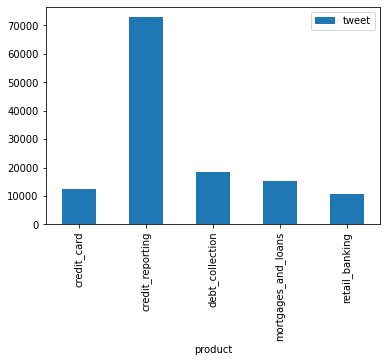

In [11]:
# Balance of train data
train_data.groupby('product').count().plot(kind='bar')
plt.show()

* credit_card, debt_collection, mortgages_and_loans, retail_banking columns consist of <b>very few values</b>. So, the values in these columns will be increased using <b>random oversampling</b>.
* Oversampling is done in train set because this will prevent <b>data leakage</b> to test set.  

# **<span style="color:	#F50C0C;">3. Random Oversampling</span>**

In [12]:
# Train set value counts 
train_data.groupby('product').count()

,tweet
product,
credit_card,12453
credit_reporting,72871
debt_collection,18524
mortgages_and_loans,15264
retail_banking,10816


In [13]:
# Randomly selecting 7000 indices in classes with low value count
import numpy as np
to_add_1 = np.random.choice(train_data[train_data['product']=='credit_card'].index,size = 7000,replace=False)   
to_add_2 = np.random.choice(train_data[train_data['product']=='debt_collection'].index,size = 7000,replace=False) 
to_add_3 = np.random.choice(train_data[train_data['product']=='mortgages_and_loans'].index,size = 7000,replace=False)  
to_add_4 = np.random.choice(train_data[train_data['product']=='retail_banking'].index,size=7000,replace=False)

# Indices to be added
to_add = np.concatenate((to_add_1, to_add_2, to_add_3, to_add_4 ))
len(to_add)

28000

In [14]:
# Forming a dataframe for randomly selected indices
df_replicate = train_data[train_data.index.isin(to_add)]
df_replicate  

,product,tweet
71482,retail_banking,received promotion offering opening checking a...
126788,debt_collection,account removed reinserted back onto credit re...
147100,credit_card,update without warning chase took away reward ...
13925,credit_card,currently business account well fargo llc sinc...
6244,credit_card,american express aggressively campaigned exist...
...,...,...
67441,mortgages_and_loans,paid car loan ally auto received email stating...
144149,mortgages_and_loans,may concern financed motorcycle yamaha dealer ...
97161,credit_card,bill due paid full statement closed day later ...
140558,credit_card,regard credit card account number ending previ...


In [15]:
# Aggregating replicated df to orinigal df
train_data = pd.concat([train_data, df_replicate])
train_data['product'].value_counts()

credit_reporting       72871
debt_collection        25524
mortgages_and_loans    22264
credit_card            19453
retail_banking         17816
Name: product, dtype: int64

As we can see, The Value counts of minority classes have <b>increased</b>. 

# **<span style="color:	#F50C0C;">4. Text Pre-Processing</span>**

In [16]:
# Importing NLTK Libraries
import nltk
from nltk.corpus import stopwords
from nltk import *

In [17]:
# Declaring function for text preprocessing 

def preprocess_text(main_df):
  df_1 = main_df.copy()

  # remove stopwords
  nltk.download('stopwords')         # Downloading stopwords
  stop = stopwords.words('english')  
  df_1['tweet'] = df_1['tweet'].apply(lambda x: " ".join(x for x in x.split() if x not in stop)) 
  
  # remove punctuations and convert to lower case
  df_1['tweet'] = df_1['tweet'].apply(lambda x: re.sub('[!@#$:).;,?&]', '', x.lower()))
  
  # remove double spaces
  df_1['tweet'] = df_1['tweet'].apply(lambda x: re.sub(' ', ' ', x))

  return df_1  

In [18]:
# Preprocessing training and test data 
train_data = preprocess_text(train_data)
test_data = preprocess_text(test_data)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [19]:
# Verifying text preprocessing
train_data['tweet'].head()

82112     notified hard inquiry credit report capital to...
71482     received promotion offering opening checking a...
126788    account removed reinserted back onto credit re...
147100    update without warning chase took away reward ...
136161    account paid reporting late payment also thats...
Name: tweet, dtype: object

# **<span style="color:	#F50C0C;">5. Label Encoding</span>**

In [20]:
# Declaring train labels
train_labels = train_data['product'] 
test_labels = test_data['product']

In [21]:
# Converting labels to numerical features
import numpy as np
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(train_labels)
train_labels = le.transform(train_labels)
test_labels = le.transform(test_labels)

print(le.classes_)
print(np.unique(train_labels, return_counts=True))
print(np.unique(test_labels, return_counts=True))

['credit_card' 'credit_reporting' 'debt_collection' 'mortgages_and_loans'
 'retail_banking']
(array([0, 1, 2, 3, 4]), array([19453, 72871, 25524, 22264, 17816], dtype=int64))
(array([0, 1, 2, 3, 4]), array([ 3113, 18301,  4624,  3726,  2719], dtype=int64))


In [22]:
# Changing labels to categorical features
import numpy as np
from tensorflow.python.keras.utils import np_utils
from tensorflow.keras.utils import to_categorical
import numpy as np

train_labels = to_categorical(np.asarray(train_labels))
test_labels = to_categorical(np.array(test_labels))

# **<span style="color:	#F50C0C;">6. Tokenizing Sentences and Fixing Sentence length</span>**

In [23]:
from tensorflow.keras.preprocessing.text import Tokenizer

# Defining training parameters
max_sequence_length = 170   
max_words = 2500   

# Tokenizing tweets/sentences wrt num_words
tokenizer = Tokenizer(num_words = max_words)  # Selects most frequent words 
tokenizer.fit_on_texts(train_data.tweet)      # Develops internal vocab based on training text
train_sequences = tokenizer.texts_to_sequences(train_data.tweet)  # converts text to sequence

test_sequences = tokenizer.texts_to_sequences(test_data.tweet)

In [24]:
# Fixing the sequence length 
from tensorflow.keras.preprocessing.sequence import pad_sequences
train_data = pad_sequences(train_sequences, maxlen = max_sequence_length)
test_data = pad_sequences(test_sequences, maxlen = max_sequence_length)
train_data.shape, test_data.shape

((157928, 170), (32483, 170))

# **<span style="color:	#F50C0C;">7. Using Bi-LSTM Model</span>**

## # 7.1 Initializing Model 

In [25]:
# Importing Libraries

import tensorflow as tf
import sys, os, re, csv, codecs, numpy as np, pandas as pd
from tensorflow.keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from tensorflow.keras.layers import Bidirectional, GlobalMaxPool1D, Conv1D, SimpleRNN
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras import initializers, regularizers, constraints, optimizers, layers
from tensorflow.keras.layers import Dense, Input, Input, Flatten, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Embedding 

In [26]:
embedding_dim = 32  

# Model Training
model = Sequential()
model.add(Embedding(max_words, 
                   embedding_dim,
                   input_length=max_sequence_length))

# Bidirectional LSTM 
model.add(Bidirectional(LSTM(16, return_sequences=True, dropout=0.4, recurrent_dropout=0)))   

model.add(GlobalMaxPool1D())

model.add(Dense(5,activation='softmax'))  

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 170, 32)           80000     
                                                                 
 bidirectional (Bidirectiona  (None, 170, 32)          6272      
 l)                                                              
                                                                 
 global_max_pooling1d (Globa  (None, 32)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 5)                 165       
                                                                 
Total params: 86,437
Trainable params: 86,437
Non-trainable params: 0
_________________________________________________________________


## 7.2 Training and Validating Model

In [28]:
model.compile(loss = 'binary_crossentropy', optimizer='RMSProp', metrics = ['accuracy'])   

In [29]:
# declaring weights of product categories
class_weight = {0: 4,          
                1: 5,    
                2: 3,      
                3: 3,     
                4: 4}      

# training and validating model 
history = model.fit(train_data, train_labels, batch_size=48, epochs= 20, class_weight = class_weight, validation_data=(test_data, test_labels)) # best 89(now) or 48 or 60 epochs # default epochs = 23 # batch_size changed to 1 (takes 2.30hrs) from 16

Epoch 1/20
3291/3291 [==============================] - 1159s 346ms/step - loss: 1.0129 - accuracy: 0.6922 - val_loss: 0.1676 - val_accuracy: 0.8458
Epoch 2/20
3291/3291 [==============================] - 1384s 421ms/step - loss: 0.6162 - accuracy: 0.8445 - val_loss: 0.1458 - val_accuracy: 0.8622
Epoch 3/20
3291/3291 [==============================] - 1132s 344ms/step - loss: 0.5679 - accuracy: 0.8565 - val_loss: 0.1399 - val_accuracy: 0.8693
Epoch 4/20
3291/3291 [==============================] - 879s 267ms/step - loss: 0.5478 - accuracy: 0.8613 - val_loss: 0.1395 - val_accuracy: 0.8692
Epoch 5/20
3291/3291 [==============================] - 813s 247ms/step - loss: 0.5368 - accuracy: 0.8638 - val_loss: 0.1372 - val_accuracy: 0.8709
Epoch 6/20
3291/3291 [==============================] - 825s 251ms/step - loss: 0.5289 - accuracy: 0.8658 - val_loss: 0.1355 - val_accuracy: 0.8723
Epoch 7/20
3291/3291 [==============================] - 879s 267ms/step - loss: 0.5215 - accuracy: 0.8677 - v

In [30]:
# Prediction on Test Data
predicted_bi_lstm = model.predict(test_data)
predicted_bi_lstm

array([[7.4018747e-01, 2.0526309e-01, 1.4532742e-02, 3.8987722e-02,
        1.0290392e-03],
       [1.3623352e-05, 2.1542461e-05, 5.6626963e-05, 9.9982327e-01,
        8.5031941e-05],
       [3.4250267e-04, 2.1626200e-03, 9.9737966e-01, 7.3328272e-05,
        4.1900861e-05],
       ...,
       [1.6711398e-06, 9.9999154e-01, 5.6579993e-06, 1.0242768e-06,
        1.5288389e-07],
       [4.6758432e-06, 9.9993777e-01, 4.0257175e-05, 2.2025697e-06,
        1.5197078e-05],
       [3.4707721e-06, 6.2486592e-06, 1.4104297e-05, 9.9997246e-01,
        3.8231105e-06]], dtype=float32)

# **<span style="color:	#F50C0C;">8. Model Evaluation</span>**

## 8.1Model Performance Attributes

In [31]:
import sklearn
from sklearn.metrics import precision_recall_fscore_support as score
precision, recall, fscore, support = score(test_labels, predicted_bi_lstm.round())

print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))
print('################################')
print(sklearn.metrics.classification_report(test_labels, predicted_bi_lstm.round()))

precision: [0.79569892 0.91877954 0.83706311 0.87091172 0.81342547]
recall: [0.7844523  0.93459374 0.71993945 0.80756844 0.90915778]
fscore: [0.79003559 0.92661917 0.77409604 0.83804484 0.85863147]
support: [ 3113 18301  4624  3726  2719]
################################
              precision    recall  f1-score   support

           0       0.80      0.78      0.79      3113
           1       0.92      0.93      0.93     18301
           2       0.84      0.72      0.77      4624
           3       0.87      0.81      0.84      3726
           4       0.81      0.91      0.86      2719

   micro avg       0.88      0.87      0.88     32483
   macro avg       0.85      0.83      0.84     32483
weighted avg       0.88      0.87      0.88     32483
 samples avg       0.87      0.87      0.87     32483



c:\users\user\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## 8.2 Model Performance with Epochs

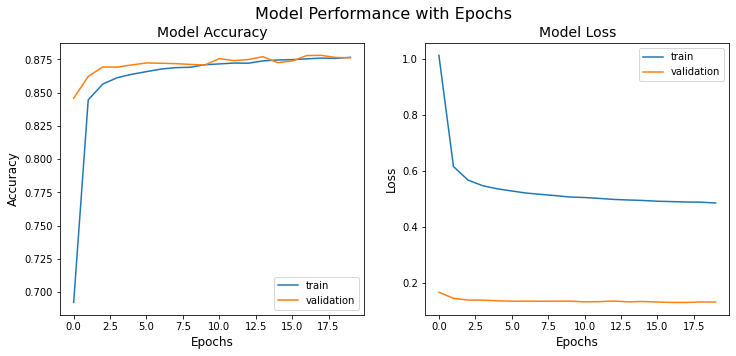

In [32]:
def accuracy_plot(history):
    
    fig, ax = plt.subplots(1, 2, figsize=(12,5))
    
    fig.suptitle('Model Performance with Epochs', fontsize = 16)
    # Subplot 1 
    ax[0].plot(history.history['accuracy'])
    ax[0].plot(history.history['val_accuracy'])
    ax[0].set_title('Model Accuracy', fontsize = 14)
    ax[0].set_xlabel('Epochs', fontsize = 12)
    ax[0].set_ylabel('Accuracy', fontsize = 12)
    ax[0].legend(['train', 'validation'], loc='best')
    
    # Subplot 2
    ax[1].plot(history.history['loss'])
    ax[1].plot(history.history['val_loss'])
    ax[1].set_title('Model Loss', fontsize = 14)
    ax[1].set_xlabel('Epochs', fontsize = 12)
    ax[1].set_ylabel('Loss', fontsize = 12)
    ax[1].legend(['train', 'validation'], loc='best')
    
    
accuracy_plot(history)

## 8.3 Confusion Matrix

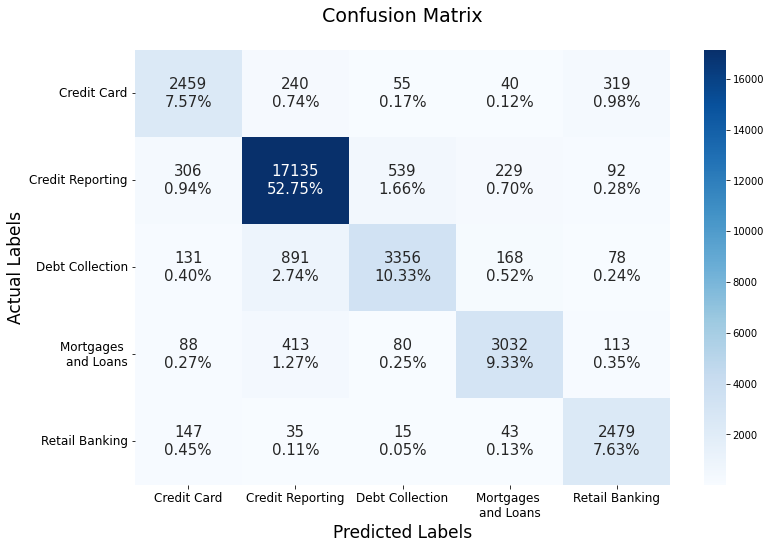

In [33]:
# Declaring function for plotting confusion matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_cm(model, test_data, test_labels):
    
    products = ['Credit Card', 'Credit Reporting', 'Debt Collection', 'Mortgages \nand Loans', 'Retail Banking']
        
    # Calculate predictions
    pred = model.predict(test_data)
    
    # Declaring confusion matrix
    cm = confusion_matrix(np.argmax(np.array(test_labels),axis=1), np.argmax(pred, axis=1))
    
    # Heat map labels

    group_counts = ['{0:0.0f}'.format(value) for value in cm.flatten()]
    group_percentages = ['{0:.2%}'.format(value) for value in cm.flatten()/np.sum(cm)]
    
    labels = [f"{v2}\n{v3}" for v2, v3 in zip(group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(5,5)

    # Plotting confusion matrix
    plt.figure(figsize=(12,8))
    
    sns.heatmap(cm, cmap=plt.cm.Blues, annot=labels, annot_kws={"size": 15}, fmt = '',
                xticklabels = products,
                yticklabels = products)
    
    plt.xticks(fontsize = 12)
    plt.yticks(fontsize = 12, rotation = 'horizontal')
    plt.title('Confusion Matrix\n', fontsize=19)
    plt.xlabel('Predicted Labels', fontsize=17)
    plt.ylabel('Actual Labels', fontsize=17)
    
plot_cm(model, test_data, test_labels)

Model <b>accuracy</b> is verified with confusion matrix. The Model Loss is same with confusion matrix